In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [1]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from bayesian.train_bn import parameter_learning
from sklearn.model_selection import train_test_split
from gmr import GMM
from gmr.utils import check_random_state
from scipy import stats
from sklearn.datasets import make_spd_matrix, make_sparse_spd_matrix
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from bayesian.calculate_accuracy import calculate_acc, parall_accuracy
import cpuinfo
from scipy import integrate
import math
from scipy.linalg import sqrtm
from mpl_toolkits.mplot3d import Axes3D 
from bayesian.train_bn import structure_learning, parameter_learning, parameter_learning_mix, component, n_component
from preprocess.discretization import get_nodes_type, discretization, inverse_discretization, code_categories, get_nodes_sign
from bayesian.save_bn import save_structure, save_params, read_structure, read_params
from external.libpgm.hybayesiannetwork import HyBayesianNetwork
from bayesian.calculate_accuracy import calculate_acc, LOO_validation, parall_accuracy
from joblib import Parallel, delayed
import cpuinfo
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## Генерация синтетических данных для проверки сетей со смесями

In [3]:
bn = dict()
bn['V'] = ['D1', 'D2', 'N1', 'N2', 'N3']
bn['E'] = [['D1', 'N1'],  ['D2', 'N1'], ['D2', 'N2'], ['N1', 'N3'], ['N1', 'N2']]

In [4]:
node_types = {'D1':'disc', 'D2': 'disc', 'N1': 'cont', 'N2': 'cont', 'N3': 'cont'}

In [5]:
n1 = 2
x1 = np.arange(n1)
p1 = tuple(np.random.dirichlet(np.ones(n1),size=1)[0])
custm1 = stats.rv_discrete(name='custm1', values=(x1, p1))

In [6]:
n2 = 4
x2 = np.arange(n2)
p2 = tuple(np.random.dirichlet(np.ones(n2),size=1)[0])
custm2 = stats.rv_discrete(name='custm2', values=(x2, p2))

In [7]:
mean = dict()
cov = dict()
for i in x1:
    for j in x2:
        n = random.randint(2,4)
        means = []
        covs = []
        for _ in range(n):
            means.append([random.randint(-1000, 1000), random.randint(-1000, 1000), random.randint(-1000, 1000)])
            covs.append(make_spd_matrix(3))
        mean[str(i)+str(j)] = means
        cov[str(i)+str(j)] = covs


In [8]:
df = pd.DataFrame(columns=['D1', 'D2', 'N1', 'N2', 'N3'])
df['D1'] = custm1.rvs(size=5000)
df['D2'] = custm2.rvs(size=5000)

In [9]:
df_new = pd.DataFrame()
for i in x1:
    for j in x2:
        sample = df.loc[(df['D1'] == i) & (df['D2'] == j)]
        size = sample.shape[0]
        means = mean[str(i)+str(j)]
        covs = cov[str(i)+str(j)]
        n = len(means)
        model = GMM(n_components=n, priors=[1/n for _ in range(n)], means=means, covariances=covs)
        cont_data = model.sample(size)
        sample[['N1', 'N2', 'N3']] = cont_data
        df_new = pd.concat([df_new, sample])
df_new.reset_index(inplace=True, drop=True)

<ipython-input-9-27497bb46744>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[['N1', 'N2', 'N3']] = cont_data
<ipython-input-9-27497bb46744>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample[['N1', 'N2', 'N3']] = cont_data
C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

In [10]:
df_new

,D1,D2,N1,N2,N3
0,0,1,14.359222,557.038768,-80.759316
1,0,1,15.488483,555.984642,-81.432751
2,0,1,14.986376,558.050609,-79.686448
3,0,1,13.818422,557.289212,-79.655574
4,0,1,13.585891,559.245474,-77.995491
...,...,...,...,...,...
4995,1,3,386.671713,-552.331815,558.468266
4996,1,3,385.669878,-552.599284,557.940901
4997,1,3,386.221799,-554.534935,558.334295
4998,1,3,385.556715,-551.196778,557.258663


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='N1', ylabel='Density'>

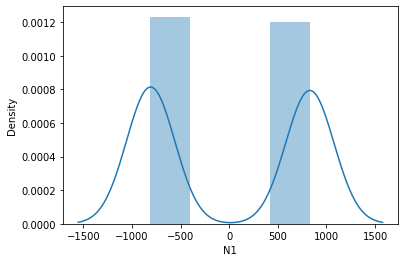

In [11]:
sample = df_new.loc[(df_new['D1'] == 0) & (df_new['D2'] == 2)]
#sns.kdeplot(df_new['N1'], df_new['N3'])
sns.distplot(sample['N1'])

In [12]:
df_new['D1'] = df_new['D1'].apply(lambda x: str(x))
df_new['D2'] = df_new['D2'].apply(lambda x: str(x))
train, test = train_test_split(df_new, test_size=0.1)
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [13]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
train['D1'] = train['D1'].apply(lambda x: str(x))
train['D2'] = train['D2'].apply(lambda x: str(x))
test['D1'] = test['D1'].apply(lambda x: str(x))
test['D2'] = test['D2'].apply(lambda x: str(x))

In [7]:
params = parameter_learning(train, node_types, bn, 'mix')
save_structure(bn, 'synth_net')
skel = read_structure('synth_net')
save_params(params, 'synth_net_param')
params = read_params('synth_net_param')
all_bn = HyBayesianNetwork(skel, params)

In [8]:
cpu_count = max(cpuinfo.get_cpu_info()['count']-1, 1)
acc, rmse, real, pred, indexes = parall_accuracy(all_bn, test, bn['V'], 'mix', cpu_count)

C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='N1', ylabel='N3'>

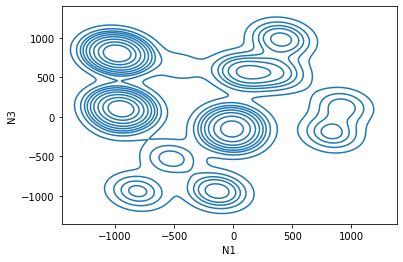

In [15]:
# sample = train.loc[(train['D1'] == '0') & (train['D2'] == '1')]
# sns.distplot(sample['N1'])
sns.kdeplot(train['N1'], train['N3'])

In [13]:
#simple
rmse

{'N1': 276.22, 'N2': 311.148, 'N3': 488.471}

In [9]:
#mix_lrts
rmse

{'N1': 274.024, 'N2': 49.506, 'N3': 381.38}

In [19]:
#mix_aic_bic
rmse

{'N1': 274.276, 'N2': 49.506, 'N3': 217.64}

In [9]:
#mix_quantile
rmse

{'N1': 275.98, 'N2': 7.852, 'N3': 189.863}

## Вычисление расстояния Махолонобиса и model-weighted distance

In [62]:
means = []
covs = []
for _ in range(2):
    means.append([random.randint(-100, -10), random.randint(10, 55)])
    covs.append(make_spd_matrix(2))
 

In [63]:
means

[[-43, 27], [-71, 47]]

In [64]:
covs

[array([[2.05072762, 0.2984639 ],
        [0.2984639 , 0.14172644]]),
 array([[ 2.16912756, -0.38252243],
        [-0.38252243,  0.2832131 ]])]

In [65]:
model = GMM(n_components=2, priors=[1/2 for _ in range(2)], means=means, covariances=covs)
sample = model.sample(100)

In [66]:
sample = pd.DataFrame(data = sample, columns=['C1', 'C2'])
sample

,C1,C2
0,-43.602316,27.068765
1,-44.643817,27.018894
2,-43.661124,26.659291
3,-43.383707,26.766429
4,-40.924506,27.303949
...,...,...
95,-69.878587,46.220091
96,-70.998668,47.052025
97,-71.447884,47.659865
98,-67.782671,46.418734


C:\Users\anaxa\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='C1', ylabel='C2'>

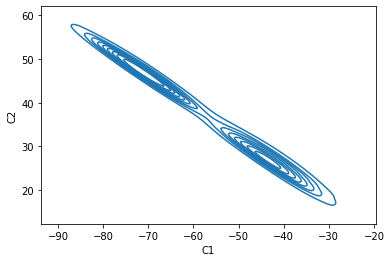

In [67]:
sns.kdeplot(sample['C1'], sample['C2'])

In [68]:
c = []
for i in model.to_responsibilities(sample):
    if i[0] == 1:
        c.append(0)
    else:
        c.append(1)


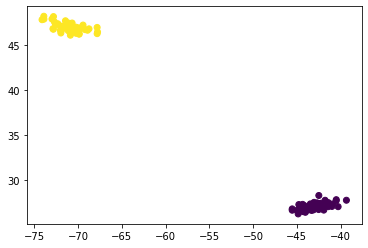

In [69]:
plt.scatter(sample['C1'], sample['C2'], c=c)

In [70]:
sample['component'] = c
sample

,C1,C2,component
0,-43.602316,27.068765,0
1,-44.643817,27.018894,0
2,-43.661124,26.659291,0
3,-43.383707,26.766429,0
4,-40.924506,27.303949,0
...,...,...,...
95,-69.878587,46.220091,1
96,-70.998668,47.052025,1
97,-71.447884,47.659865,1
98,-67.782671,46.418734,1


In [2]:
def erf(b):
    func = lambda x: np.exp(-x**2)
    return integrate.quad(func, 0, b)[0]


In [3]:
def weighted_distance(x1, x2, means, cov, w):
    v = x1 - x2
    G_nominator = 0
    G_denominator = 0
    for k in range(len(w)):
        cov_inv = np.linalg.inv(cov[k])
        pi_k = w[k]
        u = np.transpose(means[k] - np.transpose(x2))
        v_t = np.transpose(v)
        u_t = np.transpose(u)
        b2 = np.linalg.inv(np.dot(np.dot(v_t, cov_inv),v))[0][0]
        a = np.dot(np.dot(b2*v_t,cov_inv), u)[0][0]
        m = np.dot(np.dot(v_t, cov_inv), u)
        m2 = np.dot(m,m)
        Z = np.dot(np.dot(u_t,cov_inv), u) - b2*m2
        Z = Z[0][0]
        bound1 = (1 - a) / math.sqrt(2*b2)
        bound2 = -a / math.sqrt(2*b2)
        erf1 = erf(bound1)
        erf2 = erf(bound2)
        diff_erf = erf1 - erf2
        exp_power = np.exp((-1*Z)/2)
        sqrt_b2 = math.sqrt((math.pi*b2)/2)
        integral = sqrt_b2*exp_power*diff_erf
        G_nominator += np.dot(pi_k*cov_inv, integral)
        G_denominator += pi_k*integral
    G = G_nominator/G_denominator
    d = np.dot(np.dot(np.transpose(v), G),v)
    return d[0][0]
        
    

In [4]:
def mah_distance(x1, x2, cov):
    v = x1 - x2
    v_t = np.transpose(v)
    cov_inv = np.linalg.inv(cov)
    d = np.dot(np.dot(v_t, cov_inv), v)
    return d[0][0]



In [74]:
x1 = np.transpose(sample.loc[sample['component'] == 0][['C1', 'C2']].values)
x2 = np.transpose(sample.loc[sample['component'] == 1][['C1', 'C2']].values[0:42])


In [78]:
dist_matrix11 = np.empty([42, 42])
for i in range(42):
    for j in range(42):
        X1 = np.array([[x1[0][i]], [x1[1][i]]])
        X2 = np.array([[x1[0][j]], [x1[1][j]]])
        d = mah_distance(X1, X2, covs[0])
        dist_matrix11[i][j] = d

In [79]:
dist_matrix22 = np.empty([42, 42])
for i in range(42):
    for j in range(42):
        X1 = np.array([[x2[0][i]], [x2[1][i]]])
        X2 = np.array([[x2[0][j]], [x2[1][j]]])
        d = mah_distance(X1, X2, covs[1])
        dist_matrix22[i][j] = d

In [80]:
с2_mean = np.median(dist_matrix22)
с1_mean = np.median(dist_matrix11)

In [81]:
dist_matrix21 = np.empty([42, 42])
for i in range(42):
    for j in range(42):
        X1 = np.array([[x1[0][i]], [x1[1][i]]])
        X2 = np.array([[x2[0][j]], [x2[1][j]]])
        d = weighted_distance(X2, X1, means, covs, [1/2, 1/2])
        dist_matrix21[j][i] = d

In [82]:
c21_mean = np.median(dist_matrix21)

In [83]:
dist_matrix12 = np.empty([42, 42])
for i in range(42):
    for j in range(42):
        X1 = np.array([[x1[0][i]], [x1[1][i]]])
        X2 = np.array([[x2[0][j]], [x2[1][j]]])
        d = weighted_distance(X1, X2, means, covs, [1/2, 1/2])
        dist_matrix12[i][j] = d

In [84]:
c12_mean = np.median(dist_matrix12)

<AxesSubplot:>

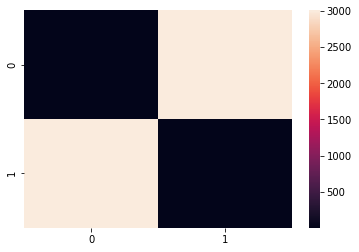

In [85]:
dists = [[с1_mean, c12_mean], [c21_mean, с2_mean]]
sns.heatmap(dists)

<AxesSubplot:>

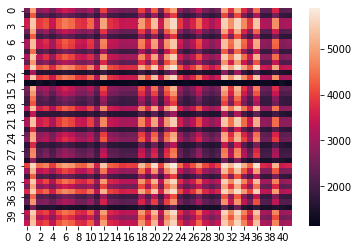

In [77]:
sns.heatmap(dist_matrix12)

In [8]:
random_state = check_random_state(0)

In [87]:
mean = []
cov = []
for k in range(3):
    mean.append([random.randint(0, 10), random.randint(0, 10), random.randint(0, 10)])
    cov.append(make_spd_matrix(3))
model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
sample = model.sample(1000)
sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
range_c1 = sample['C1'].max() - sample['C1'].min()
range_c2 = sample['C2'].max() - sample['C2'].min()
range_c3 = sample['C3'].max() - sample['C3'].min()
sample['C1'] = sample['C1'].apply(lambda x: x / range_c1)
sample['C2'] = sample['C2'].apply(lambda x: x / range_c2)
sample['C3'] = sample['C3'].apply(lambda x: x / range_c3)

In [89]:
model_new = GMM(n_components=3).from_samples(sample[['C1', 'C2', 'C3']].values)

In [90]:
model_new.means

array([[0.3797972 , 0.56099053, 0.715009  ],
       [0.09431778, 0.00672557, 0.36904361],
       [0.1022874 , 0.44196952, 0.36004776]])

## Генерация трёхмерной смеси с тремя компонентами и расчёт расстояний

In [24]:
dist_matrix = []
means = []
covs = []
w = [1/3, 1/3, 1/3]
for _ in range(300):
    print(_)
    mean = []
    cov = []
    for k in range(3):
        if k == 0:
            mean.append([random.randint(0, 50), random.randint(0, 50), random.randint(0, 50)])
        if k == 1:
            mean.append([random.randint(25, 75), random.randint(25, 75), random.randint(25, 75)])
        if k == 2:
            mean.append([random.randint(50, 100), random.randint(50, 100), random.randint(50, 100)])
        
        #scale = random.randint(1,10)
        #df = random.randint(3,5)
        #cov.append(stats.wishart.rvs(3, [scale, scale, scale], 1))
        cov.append(np.array([[ 1, 0, 0],
       [0,  1,  0],
       [0,  0,  1]]))
        #cov.append(make_spd_matrix(3))
    
    #means.append(mean)
    #covs.append(cov)
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(500)
    sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
    # range_c1 = sample['C1'].max() - sample['C1'].min()
    # range_c2 = sample['C2'].max() - sample['C2'].min()
    # range_c3 = sample['C3'].max() - sample['C3'].min()
    # sample['C1'] = sample['C1'].apply(lambda x: x / range_c1)
    # sample['C2'] = sample['C2'].apply(lambda x: x / range_c2)
    # sample['C3'] = sample['C3'].apply(lambda x: x / range_c3)
    # model_new = GMM(n_components=3).from_samples(sample[['C1', 'C2', 'C3']].values)
    means.append(mean)
    covs.append(cov)
    #means.append(mean)
    #covs.append(cov)
    # mean = model_new.means
    # cov = model_new.covariances
    # model_new = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    # sample = model_new.sample(500)
    # sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
   
    c = []
    for i in model.to_responsibilities(sample):
        c.append(i.argmax())
    sample['comp'] = c
    x1 = sample.loc[sample['comp'] == 0][['C1', 'C2', 'C3']].values
    x2 = sample.loc[sample['comp'] == 1][['C1', 'C2', 'C3']].values
    x3 = sample.loc[sample['comp'] == 2][['C1', 'C2', 'C3']].values
    length = []
    length.append(len(x1))
    length.append(len(x2))
    length.append(len(x3))
    min_len = np.min(length)
    x1 = np.transpose(x1[0:min_len])
    x2 = np.transpose(x2[0:min_len])
    x3 = np.transpose(x3[0:min_len])
    dist_matrix11 = np.empty([min_len, min_len])
    dist_matrix22 = np.empty([min_len, min_len])
    dist_matrix33 = np.empty([min_len, min_len])
    dist_matrix12 = np.empty([min_len, min_len])
    dist_matrix13 = np.empty([min_len, min_len])
    dist_matrix23 = np.empty([min_len, min_len])
    for i in range(min_len):
        for j in range(min_len):
            X1 = np.array([[x1[0][i]], [x1[1][i]], [x1[2][i]]])
            Y1 = np.array([[x1[0][j]], [x1[1][j]],  [x1[2][j]]])
            d = mah_distance(X1, Y1, cov[0])
            dist_matrix11[i][j] = d
            X2 = np.array([[x2[0][i]], [x2[1][i]],  [x2[2][i]]])
            Y2 = np.array([[x2[0][j]], [x2[1][j]], [x2[2][j]]])
            d = mah_distance(X2, Y2, cov[1])
            dist_matrix22[i][j] = d
            X3 = np.array([[x3[0][i]], [x3[1][i]], [x3[2][i]]])
            Y3 = np.array([[x3[0][j]], [x3[1][j]], [x3[2][j]]])
            d = mah_distance(X3, Y3, cov[2])
            dist_matrix33[i][j] = d
            dist_matrix12[i][j] = weighted_distance(X1,Y2,mean, cov, w)
            dist_matrix13[i][j] = weighted_distance(X1, Y3, mean, cov, w)
            dist_matrix23[i][j] = weighted_distance(X2, Y3, mean, cov, w)
    final_dist = [[np.mean(dist_matrix11), np.mean(dist_matrix12), np.mean(dist_matrix13)], [np.mean(dist_matrix12), np.mean(dist_matrix22), np.mean(dist_matrix23)], [np.mean(dist_matrix13), np.mean(dist_matrix23), np.mean(dist_matrix33)]]
    dist_matrix.append(final_dist)

    
    
    
    



0
1
2
3


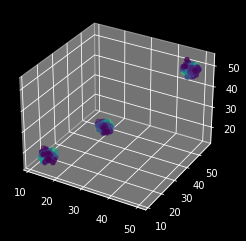

In [21]:
mean = means[4]
cov = covs[4]
model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
sample = model.sample(1000)
x = sample[:,0]
y = sample[:,1]
z = sample[:,2]
xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=density)
plt.show()

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

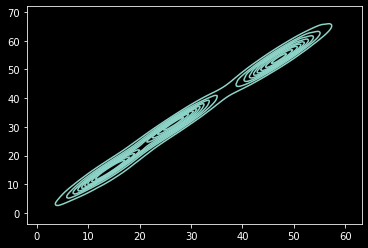

In [22]:
sns.kdeplot(x,y)

C:\Users\anaxa\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

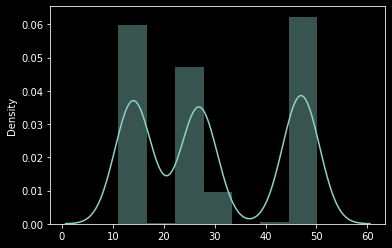

In [23]:
sns.distplot(x)

<AxesSubplot:>

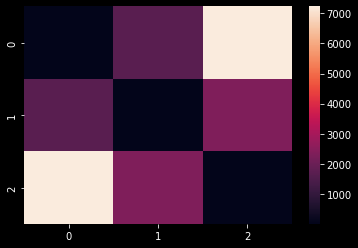

In [8]:
sns.heatmap(dist_matrix[0])

In [9]:
mean_components_dist = []
for i in range(80):
    matrix = dist_matrix[i]
    mean_components_dist.append((matrix[0][1] + matrix[0][2] + matrix[1][2]) / 3)

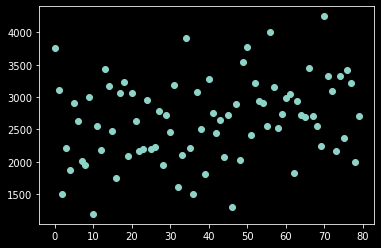

In [10]:
plt.scatter([i for i in range(80)], mean_components_dist)

## Расчёт RMSE на сети для всех сгенерированных распределений

In [12]:
cpu_count = max(cpuinfo.get_cpu_info()['count']-1, 1)
cpu_count

11

In [13]:
node_types = {'C1':'cont', 'C2':'cont', 'C3':'cont'}
columns_for_disc = ['C1', 'C2', 'C3']
rmse_all_column = []
structures = []
samples_train = []
samples_test = []
real_iter = []
pred_iter = []
for i in range(300):
    print(i)
    mean = means[i]
    cov = covs[i]
    model = GMM(n_components=3, priors=w, means=mean, covariances=cov)
    sample = model.sample(5000)
    sample = pd.DataFrame(data = sample, columns=['C1', 'C2', 'C3'])
    train, test = train_test_split(sample, test_size=0.02)
    train.reset_index(inplace=True, drop=True)
    test.reset_index(inplace=True, drop=True)
    samples_train.append(train)
    samples_test.append(test)
    discrete_data, coder = discretization(train, 'equal_frequency', columns_for_disc)
    bn_full = structure_learning(discrete_data, 'HC', node_types, 'K2')
    structures.append(bn_full['E'])
    params = parameter_learning(train, node_types, bn_full, 'mix')
    save_structure(bn_full, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    acc, rmse, real, pred, index = parall_accuracy(all_bn, test, columns_for_disc, 'mix', cpu_count)
    real_iter.append(real)
    pred_iter.append(pred)
    rmse_all_column.append(rmse)


    


0
1
2
3


KeyboardInterrupt: 

In [16]:
structures[3]

[['C1', 'C3'], ['C1', 'C2'], ['C3', 'C2']]

In [62]:
pred_iter

[[[0.08178234369494398,
   -0.4660953137774947,
   0.08177637534816859,
   -0.4660933050448203,
   -0.46609464837956366,
   0.5331415370216391,
   0.08177825296481993,
   0.5331018814142566,
   -0.46621974106845904,
   0.08177214728984353,
   0.5330156145620963,
   0.5332063884335382,
   0.5330261922097608,
   0.5331378231049434,
   0.0817851728026202,
   0.533167411466833,
   0.08179269772396844,
   0.08176719668010841,
   -0.4662240966446252,
   0.5330744855640519,
   0.08177138801417619,
   0.5332238641438644,
   0.5331632138524396,
   0.08177307256364388,
   0.5331432325445148,
   0.08176805899465478,
   -0.46605915876586396,
   -0.46619286713714053,
   0.5331058600028564,
   -0.46610521341230626,
   -0.466200435133893,
   -0.46614971347089784,
   -0.4661921953369846,
   -0.46622835607603375,
   0.08174281352959575,
   0.08174265369298038,
   0.08179315794575058,
   -0.46619571112024966,
   0.08176387937439893,
   0.5330786928361004,
   -0.46614317047209647,
   0.08178076976187373,

In [21]:
node_types = {'C1':'cont', 'C2':'cont', 'C3':'cont'}
columns_for_disc = ['C1', 'C2', 'C3']
rmse_simple = []
real_simple = []
pred_simple = []
for i in range(100):
    print(i)
    train = samples_train[0]
    test = samples_test[0]
    discrete_data, coder = discretization(train, 'equal_frequency', columns_for_disc)
    bn_full = structure_learning(discrete_data, 'HC', node_types, 'K2')
    params = parameter_learning(train, node_types, bn_full, 'simple')
    save_structure(bn_full, 'all_net')
    skel = read_structure('all_net')
    save_params(params, 'all_net_param')
    params = read_params('all_net_param')
    all_bn = HyBayesianNetwork(skel, params)
    acc, rmse, real, pred, index = parall_accuracy(all_bn, test, columns_for_disc, 'simple', cpu_count)
    real_simple.append(real)
    pred_simple.append(pred)
    rmse_simple.append(rmse)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [63]:
mean_rmse = []
for i in range(300):
    r1 = rmse_all_column[i]['C1']
    r2 = rmse_all_column[i]['C2']
    r3 = rmse_all_column[i]['C3']
    mean_rmse.append((r1 + r2 + r3) / 3)

In [24]:
rmse_decrease = []
for i in range(100):
    e1 = rmse_all_column[i]
    e2 = rmse_simple[i]
    decrease1 = 100 - ((e1['C1'] * 100) / e2['C1'])
    decrease2 = 100 - ((e1['C2'] * 100) / e2['C2'])
    decrease3 = 100 - ((e1['C3'] * 100) / e2['C3'])
    rmse_decrease.append((decrease1 + decrease2 + decrease3) / 3)

Text(0, 0.5, 'NRMSE Decrease in %')

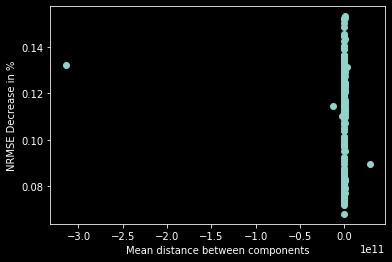

In [66]:
plt.scatter(mean_components_dist, mean_rmse)
plt.xlabel('Mean distance between components')
plt.ylabel('NRMSE Decrease in %')